In [1]:
import time
import datetime
import torch
import random
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import scale

In [2]:
# для воспроизводимости эксперимента:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
timesample = 0.004
start_time = 1.0
end_time = 2.0
n_receivers = 80
n_timesamples = int((end_time - start_time)/timesample)

data = np.empty([1,2,n_receivers,n_timesamples])

In [4]:
n_models = 1100

for i in range(n_models):
    if (i+1) % 100 == 0:
        print(i+1,'/',n_models)
    data_Z = pd.read_csv('csv_models_2frac_alpha_Z\\model_{}.csv'.format(i+1))
    model_gather_Z = np.array(data_Z[data_Z.columns[int(start_time/timesample):int(end_time/timesample)]])
    
    data_X = pd.read_csv('csv_models_2frac_alpha_X\\model_{}.csv'.format(i+1))
    model_gather_X = np.array(data_X[data_X.columns[int(start_time/timesample):int(end_time/timesample)]])
    
    model_gather = np.vstack(([model_gather_Z],[model_gather_X]))
    model_gather = np.reshape(model_gather,(1,2,n_receivers,n_timesamples))
    
    data = np.vstack((data,model_gather))
    
data = data[1:]

100 / 1100
200 / 1100
300 / 1100
400 / 1100
500 / 1100
600 / 1100
700 / 1100
800 / 1100
900 / 1100
1000 / 1100
1100 / 1100


In [5]:
print(data.shape)

(1100, 2, 80, 250)


In [6]:
# центрирование и нормализация данных
for i in range(n_models):
    for j in range(2):
        data[i,j] = scale(data[i,j], axis=1)

In [12]:
frac_params = pd.read_csv('frac_params_2frac_alpha_sys.csv')
for i in range(1100):
    if frac_params.loc[i]['alpha2'] > 0:
        frac_params.loc[i]['alpha2'] -= 180
frac_params['alpha1_rad'] = frac_params['alpha1']*math.pi/180
frac_params['alpha2_rad'] = frac_params['alpha2']*math.pi/180
frac_params['dt1'] *= 2.5
frac_params['e1'] *= 6.3
frac_params['dt2'] *= 2.5
frac_params['e2'] *= 6.3
frac_dndt = np.array(frac_params[['dn1','dt1','dn2','dt2','e1','e2']])
frac_alpha = np.array(frac_params[['alpha1_rad','alpha2_rad']])

In [13]:
X_train = torch.Tensor(data[:800])
X_validation = torch.Tensor(data[800:1100])

Y_train_dndt = torch.Tensor(frac_dndt[:800])
Y_validation_dndt = torch.Tensor(frac_dndt[800:1100])
Y_train_alpha = torch.Tensor(frac_alpha[:800])
Y_validation_alpha = torch.Tensor(frac_alpha[800:1100])

In [14]:
# изменил кол-во нейронов в полносвязных слоях
class FracAnisotropyNet(torch.nn.Module):
    def __init__(self,n1,n2,n3,n4,prob=0.0, is_alpha=False):
        super(FracAnisotropyNet,self).__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels=2, out_channels=n1, kernel_size=(2,4), padding=0, stride=2)
        self.ac1 = torch.nn.ReLU()
        self.bn1 = torch.nn.BatchNorm2d(num_features=n1)
        self.do1 = torch.nn.Dropout(p=prob)
        #self.pool1 = torch.nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.conv2 = torch.nn.Conv2d(in_channels=n1, out_channels=n2, kernel_size=2, padding=0, stride=(1,2))
        self.ac2 = torch.nn.ReLU()
        self.bn2 = torch.nn.BatchNorm2d(num_features=n2)
        self.do2 = torch.nn.Dropout(p=prob)
        
        self.conv3 = torch.nn.Conv2d(in_channels=n2, out_channels=n3, kernel_size=(2,3), padding=1, stride=(1,2))
        self.ac3 = torch.nn.ReLU()
        self.bn3 = torch.nn.BatchNorm2d(num_features=n3)
        self.do3 = torch.nn.Dropout(p=prob)
        
        self.conv4 = torch.nn.Conv2d(in_channels=n3, out_channels=n4, kernel_size=2, padding=0, stride=2)
        self.ac4 = torch.nn.ReLU()
        self.bn4 = torch.nn.BatchNorm2d(num_features=n4)
        self.do4 = torch.nn.Dropout(p=prob)
        self.pool4 = torch.nn.MaxPool2d(kernel_size=(2,1), stride=(2,1))
        
        self.fc1 = torch.nn.Linear(10*15*n4,200)
        self.ac1_ = torch.nn.Tanh()
        #self.bn1_ = torch.nn.BatchNorm1d(num_features=100)
        self.fc2 = torch.nn.Linear(200,80)
        self.ac2_ = torch.nn.Tanh()
        #self.bn2_ = torch.nn.BatchNorm1d(num_features=40)
        self.fc3 = torch.nn.Linear(80,20)
        self.ac3_ = torch.nn.Tanh()
        
        if is_alpha:
            self.out = torch.nn.Linear(20,2)
        else:
            self.out = torch.nn.Linear(20,6)
        
    def forward(self,x):
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
        
        x = self.conv1(x)
        x = self.ac1(x)
        x = self.bn1(x)
        x = self.do1(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
            
        x = self.conv2(x)
        x = self.ac2(x)
        x = self.bn2(x)
        x = self.do2(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
            
        x = self.conv3(x)
        x = self.ac3(x)
        x = self.bn3(x)
        x = self.do3(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
        #x = self.pool3(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
        
        x = self.conv4(x)
        x = self.ac4(x)
        x = self.bn4(x)
        x = self.do4(x)
        x = self.pool4(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        
        x = self.fc1(x)
        x = self.ac1_(x)
        #x = self.bn1_(x)
        x = self.fc2(x)
        x = self.ac2_(x)
        #x = self.bn2_(x)
        x = self.fc3(x)
        x = self.ac3_(x)
            
        x = self.out(x)
        
        return x

In [15]:
device = torch.device('cpu')
device2 = torch.device('cpu')

neural_net_dndt = FracAnisotropyNet(6,8,6,4, prob=0.01)
neural_net_dndt = neural_net_dndt.to(device)

loss_dndt = torch.nn.MSELoss()
optimizer_dndt = torch.optim.Adam(neural_net_dndt.parameters(), lr=3.0e-4)
########################################
neural_net_alpha = FracAnisotropyNet(6,8,6,4, prob=0.01, is_alpha=True)
neural_net_alpha = neural_net_alpha.to(device2)

loss_alpha = torch.nn.MSELoss()
optimizer_alpha = torch.optim.Adam(neural_net_alpha.parameters(), lr=3.0e-4)

In [16]:
batch_size = 100
N = len(X_train)

test_loss_history_dndt = []
train_loss_history_dndt = []

X_validation = X_validation.to(device)
Y_validation_dndt = Y_validation_dndt.to(device)

start_time = datetime.datetime.now()
epochs = 200

for epoch in range(epochs):
    order = np.random.permutation(N)
  
    loss_sum_dndt = 0.0
    
    for batch_init in range(0,N,batch_size):
        optimizer_dndt.zero_grad()
        neural_net_dndt.train()
    
        X_batch = X_train[order[batch_init:batch_init+batch_size]].to(device)
        y_batch_dndt = Y_train_dndt[order[batch_init:batch_init+batch_size]].to(device)
    
        pred_dndt = neural_net_dndt.forward(X_batch)
        #loss_value = weighted_loss(pred,y_batch)
        loss_value_dndt = loss_dndt(pred_dndt,y_batch_dndt)
        loss_sum_dndt += loss_value_dndt
        loss_value_dndt.backward()
    
        optimizer_dndt.step()
    
    neural_net_dndt.eval()
    pred_dndt = neural_net_dndt.forward(X_validation)
  
    tr_l_dndt = loss_sum_dndt/(N/batch_size)
    te_l_dndt = loss_dndt(pred_dndt,Y_validation_dndt)
    train_loss_history_dndt.append(tr_l_dndt.data.cpu())
    test_loss_history_dndt.append(te_l_dndt.data.cpu())
  
    print('epoch #', epoch+1,':\nDn, Dt:\n\tTrain Loss:\t',tr_l_dndt.data.cpu().numpy(),'\n\tTest Loss:\t',te_l_dndt.data.cpu().numpy())

educ_time = datetime.datetime.now() - start_time
print('Time elapsed:', educ_time)

epoch # 1 :
Dn, Dt:
	Train Loss:	 0.11491134 
	Test Loss:	 0.14291736
epoch # 2 :
Dn, Dt:
	Train Loss:	 0.026606351 
	Test Loss:	 0.05073462
epoch # 3 :
Dn, Dt:
	Train Loss:	 0.020868918 
	Test Loss:	 0.020431163
epoch # 4 :
Dn, Dt:
	Train Loss:	 0.018772107 
	Test Loss:	 0.016198091
epoch # 5 :
Dn, Dt:
	Train Loss:	 0.016919287 
	Test Loss:	 0.014472159
epoch # 6 :
Dn, Dt:
	Train Loss:	 0.01528585 
	Test Loss:	 0.013281629
epoch # 7 :
Dn, Dt:
	Train Loss:	 0.014116379 
	Test Loss:	 0.012248907
epoch # 8 :
Dn, Dt:
	Train Loss:	 0.012872058 
	Test Loss:	 0.011395491
epoch # 9 :
Dn, Dt:
	Train Loss:	 0.01196358 
	Test Loss:	 0.010598442
epoch # 10 :
Dn, Dt:
	Train Loss:	 0.01105082 
	Test Loss:	 0.009633547
epoch # 11 :
Dn, Dt:
	Train Loss:	 0.0100419205 
	Test Loss:	 0.008871603
epoch # 12 :
Dn, Dt:
	Train Loss:	 0.0091868825 
	Test Loss:	 0.008040326
epoch # 13 :
Dn, Dt:
	Train Loss:	 0.008434178 
	Test Loss:	 0.0073694875
epoch # 14 :
Dn, Dt:
	Train Loss:	 0.007841296 
	Test Loss:	 0.

epoch # 111 :
Dn, Dt:
	Train Loss:	 0.00100708 
	Test Loss:	 0.0008516372
epoch # 112 :
Dn, Dt:
	Train Loss:	 0.001043267 
	Test Loss:	 0.00071346335
epoch # 113 :
Dn, Dt:
	Train Loss:	 0.001027745 
	Test Loss:	 0.00047859238
epoch # 114 :
Dn, Dt:
	Train Loss:	 0.0009775322 
	Test Loss:	 0.00042846205
epoch # 115 :
Dn, Dt:
	Train Loss:	 0.00096088863 
	Test Loss:	 0.00042831496
epoch # 116 :
Dn, Dt:
	Train Loss:	 0.0009200232 
	Test Loss:	 0.00043434493
epoch # 117 :
Dn, Dt:
	Train Loss:	 0.00093047053 
	Test Loss:	 0.00043093934
epoch # 118 :
Dn, Dt:
	Train Loss:	 0.0009122685 
	Test Loss:	 0.00043607477
epoch # 119 :
Dn, Dt:
	Train Loss:	 0.00090609095 
	Test Loss:	 0.00042832998
epoch # 120 :
Dn, Dt:
	Train Loss:	 0.00094362826 
	Test Loss:	 0.00050285604
epoch # 121 :
Dn, Dt:
	Train Loss:	 0.00090896146 
	Test Loss:	 0.0003997681
epoch # 122 :
Dn, Dt:
	Train Loss:	 0.0009223701 
	Test Loss:	 0.00048540955
epoch # 123 :
Dn, Dt:
	Train Loss:	 0.00095247256 
	Test Loss:	 0.0004755423


In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
num = 30
def moving_average(a, n=num): # среднее скользящее среднее
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

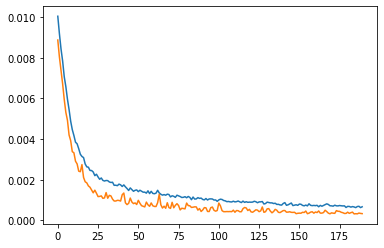

In [18]:
plt.plot(train_loss_history_dndt[10:])
plt.plot(test_loss_history_dndt[10:])

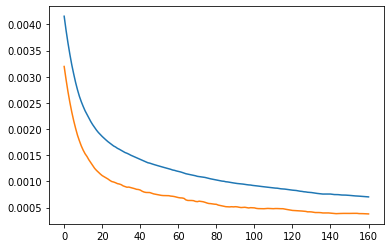

In [19]:
avg_loss_train = moving_average(train_loss_history_dndt)
avg_loss_test = moving_average(test_loss_history_dndt)
plt.plot(avg_loss_train[10:])
plt.plot(avg_loss_test[10:])

In [20]:
pred = neural_net_dndt.forward(X_validation)
pred = pred.data.cpu().numpy()
y_val = Y_validation_dndt.data.cpu().numpy()
print('Predicted\nReal value\nDifference\n')

sum_dn1_sq = 0.0
sum_dt1_sq = 0.0
sum_dn1 = 0.0
sum_dt1 = 0.0
sum_dn1_real = 0.0
sum_dt1_real = 0.0
sum_e1 = 0.0
sum_e1_sq = 0.0
sum_e1_real = 0.0

sum_dn2_sq = 0.0
sum_dt2_sq = 0.0
sum_dn2 = 0.0
sum_dt2 = 0.0
sum_dn2_real = 0.0
sum_dt2_real = 0.0
sum_e2 = 0.0
sum_e2_sq = 0.0
sum_e2_real = 0.0

for i in range(300):
    # dt1
    pred[i][1] /= 2.5
    y_val[i][1] /= 2.5
    
    # e1
    pred[i][4] /= 6.3
    y_val[i][4] /= 6.3
    
    # dt2
    pred[i][3] /= 2.5
    y_val[i][3] /= 2.5
    
    # e2
    pred[i][5] /= 6.3
    y_val[i][5] /= 6.3
    
    dif = abs(pred[i]-y_val[i])
    print(pred[i],'\n',y_val[i],'\n',abs(pred[i]-y_val[i]),'\n')
    
    sum_dn1_sq += dif[0]**2
    sum_dt1_sq += dif[1]**2
    sum_e1_sq += dif[4]**2
    sum_dn1 += dif[0]
    sum_dt1 += dif[1]
    sum_e1 += dif[4]
    sum_dn2_sq += dif[2]**2
    sum_dt2_sq += dif[3]**2
    sum_e2_sq += dif[5]**2
    sum_dn2 += dif[2]
    sum_dt2 += dif[3]
    sum_e2 += dif[5]
    
    sum_dn1_real += y_val[i][0]
    sum_dt1_real += y_val[i][1]
    sum_e1_real += y_val[i][4]
    sum_dn2_real += y_val[i][2]
    sum_dt2_real += y_val[i][3]
    sum_e2_real += y_val[i][5]
    
mean_dn1 = sum_dn1/300
mean_dt1 = sum_dt1/300
mean_e1 = sum_e1/300
mean_dn1_sq = sum_dn1_sq/300
mean_dt1_sq = sum_dt1_sq/300
mean_e1_sq = sum_e1_sq/300
relative_dn1 = sum_dn1/sum_dn1_real
relative_dt1 = sum_dt1/sum_dt1_real
relative_e1 = sum_e1/sum_e1_real

mean_dn2 = sum_dn2/300
mean_dt2 = sum_dt2/300
mean_e2 = sum_e2/300
mean_dn2_sq = sum_dn2_sq/300
mean_dt2_sq = sum_dt2_sq/300
mean_e2_sq = sum_e2_sq/300
relative_dn2 = sum_dn2/sum_dn2_real
relative_dt2 = sum_dt2/sum_dt2_real
relative_e2 = sum_e2/sum_e2_real

Predicted
Real value
Difference

[0.11324526 0.03726438 0.48466235 0.17146608 0.01669488 0.07739963] 
 [0.10726304 0.03779847 0.48465306 0.17078708 0.01697387 0.07669408] 
 [5.9822202e-03 5.3409114e-04 9.2983246e-06 6.7900121e-04 2.7899258e-04
 7.0555508e-04] 

[0.48442852 0.17085257 0.33018494 0.11334473 0.07624145 0.05282596] 
 [0.48142624 0.16964999 0.35686705 0.12575653 0.07618345 0.05647254] 
 [3.0022860e-03 1.2025833e-03 2.6682109e-02 1.2411803e-02 5.8002770e-05
 3.6465749e-03] 

[ 0.07306121  0.10349461 -0.01336915  0.06923258  0.01018001  0.00132229] 
 [0.07684998 0.13014574 0.01395303 0.04647166 0.01216115 0.002208  ] 
 [0.00378877 0.02665114 0.02732218 0.02276092 0.00198114 0.00088571] 

[0.31005168 0.11035528 0.04039557 0.02829852 0.04761894 0.00655976] 
 [0.3021265  0.10646647 0.03769681 0.00142247 0.0478101  0.00596534] 
 [0.00792518 0.00388881 0.00269876 0.02687605 0.00019116 0.00059442] 

[0.39596915 0.14042866 0.44274515 0.15619254 0.06233897 0.07169285] 
 [0.3856453  0

[0.43828988 0.15515815 0.18449989 0.05820875 0.07002485 0.02981025] 
 [0.43617967 0.15370552 0.18975033 0.0668662  0.06902339 0.0300271 ] 
 [0.00211021 0.00145262 0.00525044 0.00865744 0.00100146 0.00021685] 

[0.14908715 0.04438256 0.29230052 0.10710832 0.02212555 0.04729692] 
 [0.1482022  0.05222503 0.29804674 0.10502881 0.0234523  0.0471645 ] 
 [0.00088495 0.00784247 0.00574622 0.00207951 0.00132675 0.00013242] 

[0.37410957 0.1313778  0.16491568 0.05388112 0.05908146 0.02627827] 
 [0.36365125 0.12814721 0.17200613 0.0606133  0.05754611 0.02721916] 
 [0.01045832 0.00323059 0.00709045 0.00673218 0.00153536 0.00094089] 

[0.3947708  0.14338706 0.15355048 0.05137954 0.06268527 0.02444605] 
 [0.3853498  0.13579357 0.15156674 0.05341066 0.0609798  0.02398473] 
 [0.00942099 0.0075935  0.00198373 0.00203112 0.00170547 0.00046132] 

[0.21884833 0.07701968 0.61492133 0.2205898  0.03459959 0.0970123 ] 
 [0.22144294 0.07803436 0.61348003 0.21618447 0.0350423  0.09708034] 
 [2.5946051e-03 1.014

 [0.5243798  0.18478641 0.25410867 0.08954546 0.08298064 0.04021151] 
 [0.00847733 0.002645   0.01198399 0.00484203 0.00112962 0.0013084 ] 

[0.38807565 0.13790545 0.19811672 0.06412544 0.06213481 0.03136332] 
 [0.3848873  0.1356306  0.19528203 0.06881551 0.06090662 0.03090247] 
 [0.00318834 0.00227486 0.00283469 0.00469007 0.00122819 0.00046085] 

[0.4611209  0.16105495 0.43417042 0.15333912 0.07167    0.06994541] 
 [0.45444483 0.16014199 0.4473341  0.15763626 0.07191376 0.07078853] 
 [0.00667608 0.00091296 0.01316369 0.00429714 0.00024376 0.00084312] 

[0.527822   0.18438466 0.57524043 0.20544097 0.08302139 0.09191464] 
 [0.5086634  0.17924811 0.6065901  0.21375653 0.08049361 0.09599005] 
 [0.0191586  0.00513655 0.03134966 0.00831556 0.00252778 0.00407541] 

[0.19338469 0.06764384 0.10311949 0.04433065 0.03034163 0.01776747] 
 [0.20350367 0.07171274 0.09962086 0.00644404 0.0322035  0.01576453] 
 [0.01011898 0.0040689  0.00349862 0.0378866  0.00186187 0.00200293] 

[0.39133626 0.13936

 [0.00517629 0.00396954 0.00148791 0.00310621 0.00051956 0.00104296] 

[0.45019698 0.16059756 0.3739437  0.1341798  0.07098221 0.05962824] 
 [0.4512622  0.15902047 0.38071352 0.13415979 0.07141013 0.06024613] 
 [1.0652244e-03 1.5770942e-03 6.7698359e-03 2.0012259e-05 4.2791665e-04
 6.1788782e-04] 

[0.40933168 0.14310685 0.33103982 0.11572678 0.06532379 0.0543211 ] 
 [0.40835798 0.14390144 0.34739438 0.12241844 0.06462074 0.05497354] 
 [0.0009737  0.00079459 0.01635456 0.00669166 0.00070305 0.00065243] 

[0.4044087  0.14496128 0.1285395  0.04181071 0.06427826 0.0208483 ] 
 [0.39656672 0.13974631 0.1308367  0.04610559 0.06275482 0.02070429] 
 [0.00784197 0.00521497 0.00229719 0.00429488 0.00152344 0.00014401] 

[0.5982637  0.20897421 0.1508778  0.05769099 0.09457011 0.02452401] 
 [0.58403087 0.20580688 0.19176704 0.06757686 0.09242015 0.03034623] 
 [0.01423281 0.00316733 0.04088923 0.00988587 0.00214996 0.00582222] 

[0.20426814 0.06520761 0.5587885  0.20270336 0.03156417 0.08973922] 
 

In [21]:
print('Dn1 mean: ', mean_dn1)
print('Dt1 mean: ', mean_dt1)
print('e1 mean: ', mean_e1)
print('Dn2 mean: ', mean_dn2)
print('Dt2 mean: ', mean_dt2)
print('e2 mean: ', mean_e2)
print('Dn1 MSE: ', math.sqrt(mean_dn1_sq))
print('Dt1 MSE: ', math.sqrt(mean_dt1_sq))
print('e1 MSE: ', math.sqrt(mean_e1_sq))
print('Dn2 MSE: ', math.sqrt(mean_dn2_sq))
print('Dt2 MSE: ', math.sqrt(mean_dt2_sq))
print('e2 MSE: ', math.sqrt(mean_e2_sq))
print('Dn1 Relative: ', relative_dn1)
print('Dt1 Relative: ', relative_dt1)
print('e1 Relative: ', relative_e1)
print('Dn2 Relative: ', relative_dn2)
print('Dt2 Relative: ', relative_dt2)
print('e2 Relative: ', relative_e2)

Dn1 mean:  0.006669558908324689
Dt1 mean:  0.005011336800331871
e1 mean:  0.0010646642548575377
Dn2 mean:  0.014244381034125885
Dt2 mean:  0.007261430950214465
e2 mean:  0.0019425576354842632
Dn1 MSE:  0.00828229573772139
Dt1 MSE:  0.008939806403305543
e1 MSE:  0.0013008992284487958
Dn2 MSE:  0.019030666678830674
Dt2 MSE:  0.010768568844541214
e2 MSE:  0.0026123482667237585
Dn1 Relative:  0.02259350745210286
Dt1 Relative:  0.04178473226398914
e1 Relative:  0.022791261454366378
Dn2 Relative:  0.04321964584352395
Dt2 Relative:  0.05716914550587403
e2 Relative:  0.03724608932792847


In [22]:
# проверим как предсказанные значения связаны с аналитической формулой
Vs = 2750
Vp = 5000
g = (Vs**2)/(Vp**2)
print('e1 (crack density)\tDn1 formula\tPredicted value\tDifference')
sum_dif = 0.0
for i in range(300):
    e_pred = pred[i][4]
    formula = 4*e_pred/(3*g*(1-g))
    dn_pred = pred[i][0]
    dif = abs(dn_pred-formula)
    sum_dif += dif
    print(e_pred,'\t',formula,'\t',dn_pred,'\t',dif)

e1 (crack density)	Dn1 formula	Predicted value	Difference
0.016694881 	 0.10550000349600544 	 0.11324526 	 0.007745260199711418
0.07624145 	 0.481792776778864 	 0.48442852 	 0.002635748192144294
0.010180009 	 0.06433055385240549 	 0.07306121 	 0.008730659044895228
0.047618944 	 0.30091851344976267 	 0.31005168 	 0.009133166161443385
0.062338967 	 0.39393878966410706 	 0.39596915 	 0.002030362786454465
0.088621125 	 0.5600236950159645 	 0.5597531 	 0.0002705750704383725
0.039990667 	 0.25271312383254757 	 0.25220078 	 0.0005123415335058223
0.0021399423 	 0.01352294245601196 	 0.017919034 	 0.004396091309780886
0.013958032 	 0.08820502814548632 	 0.09419249 	 0.005987461836164984
0.088383384 	 0.5585213403963467 	 0.55876154 	 0.00024019667869601413
0.05347065 	 0.3378972051710449 	 0.3408683 	 0.0029710890679993107
0.08853663 	 0.5594897326937017 	 0.5557159 	 0.0037738141527471347
0.06050027 	 0.38231951811126313 	 0.38270324 	 0.0003837265748635743
0.047237106 	 0.29850556026796116 	 

0.088730946 	 0.5607176906627466 	 0.5586587 	 0.002058971599941395
0.05655259 	 0.3573729170629731 	 0.3610745 	 0.0037015901735076295
0.044000622 	 0.27805324018720157 	 0.28820056 	 0.01014731704470151
0.021453382 	 0.13557041348293933 	 0.14420111 	 0.008630701290810977
0.01224065 	 0.07735237106816968 	 0.07949795 	 0.00214557722074786
0.047529604 	 0.3003539475202808 	 0.29948598 	 0.0008679660558947866
0.08415527 	 0.531802602160185 	 0.52971905 	 0.0020835474612409532
0.01761309 	 0.11130244742473093 	 0.11481039 	 0.003507944835820523
0.024423009 	 0.15433638064098587 	 0.14919655 	 0.005139830390932465
0.009349286 	 0.059080964088091534 	 0.057295024 	 0.00178593969310252
0.010464907 	 0.0661309110973185 	 0.06864919 	 0.002518276586740642
0.035570316 	 0.22477958717844515 	 0.22828667 	 0.0035070814798113803
0.0685863 	 0.43341756068281967 	 0.42854607 	 0.0048714896302684
0.09044745 	 0.571564786122982 	 0.57187015 	 0.0003053620589332784
0.0728902 	 0.4606152218307227 	 0.

In [23]:
print('Mean difference between predicted value and formula for Dn1: ', sum_dif/300)
print('Relative difference between predicted value and formula for Dn1: ', sum_dif/abs(sum_dn1_real))

Mean difference between predicted value and formula for Dn1:  0.003595866152251287
Relative difference between predicted value and formula for Dn1:  0.012181199660182806


In [24]:
# проверим как предсказанные значения связаны с аналитической формулой
print('e2 (crack density)\tDn2 formula\tPredicted value\tDifference')
sum_dif = 0.0
for i in range(300):
    e_pred = pred[i][5]
    formula = 4*e_pred/(3*g*(1-g))
    dn_pred = pred[i][2]
    dif = abs(dn_pred-formula)
    sum_dif += dif
    print(e_pred,'\t',formula,'\t',dn_pred,'\t',dif)

e2 (crack density)	Dn2 formula	Predicted value	Difference
0.077399634 	 0.48911170006900073 	 0.48466235 	 0.004449346076538574
0.052825965 	 0.33382325297804943 	 0.33018494 	 0.003638316454611934
0.0013222889 	 0.008355943441016686 	 -0.01336915 	 0.021725093900783074
0.0065597584 	 0.041453098000047574 	 0.040395565 	 0.0010575326690653655
0.07169285 	 0.45304878598189313 	 0.44274515 	 0.010303636846303532
0.0061119264 	 0.038623111816796174 	 0.0371152 	 0.0015079104627693796
0.09048797 	 0.5718208676916963 	 0.57009023 	 0.001730633412063698
0.08353239 	 0.5278664603646204 	 0.52480805 	 0.003058411162655039
0.042246643 	 0.2669693198895635 	 0.26134422 	 0.005625095675009684
0.0239562 	 0.15138647539990857 	 0.14266056 	 0.008725917176184206
0.088640094 	 0.5601435669913178 	 0.5553247 	 0.004818893338668917
0.007944897 	 0.050206206374721764 	 0.05155816 	 0.0013519529170224684
0.077117 	 0.487325673551699 	 0.47381502 	 0.01351064965262061
0.011166793 	 0.07056634485935226 	 0

0.08914705 	 0.563347199677477 	 0.55652744 	 0.006819763897905506
0.07231882 	 0.45700451408607784 	 0.4495688 	 0.007435706007311971
0.007270726 	 0.04594591646827153 	 0.0341667 	 0.011779215330251967
0.042756833 	 0.27019336282761425 	 0.27773076 	 0.007537400130912364
0.09308921 	 0.5882588655310649 	 0.5851269 	 0.003131988700010191
0.07309989 	 0.46194031094083343 	 0.45090246 	 0.011037848935218197
0.02152171 	 0.13600219506894518 	 0.12676734 	 0.009234857746710068
0.022508904 	 0.14224057561188738 	 0.14563951 	 0.0033989333507438435
0.016611317 	 0.10497193825344131 	 0.09304743 	 0.011924505651989437
0.08201478 	 0.5182761844291609 	 0.5169136 	 0.0013625916137617322
0.08861341 	 0.5599749646567773 	 0.5562443 	 0.003730650939888891
0.057212867 	 0.3615454128712137 	 0.36075363 	 0.0007917872398813253
0.025878875 	 0.16353643704316653 	 0.15871233 	 0.0048241095628503705
0.021870296 	 0.13820501917533365 	 0.13525727 	 0.002947745262903839
0.005045779 	 0.03188580419654778 

0.09658573 	 0.6103544345308314 	 0.6079915 	 0.002362917940712972
0.077178486 	 0.4877141981159625 	 0.4806434 	 0.0070708065067706105
0.0683482 	 0.4319129461045149 	 0.4286417 	 0.0032712393994215327
0.024902938 	 0.15736919811639039 	 0.15795267 	 0.0005834681662634233
0.012093158 	 0.07642032643969639 	 0.07854586 	 0.002125534506482049
0.0052651456 	 0.03327204755331485 	 0.031806074 	 0.0014659734704634414
0.09183006 	 0.5803019276541206 	 0.5714564 	 0.008845554916236065
0.003803027 	 0.02403247865729443 	 0.03214162 	 0.008109139773320041
0.04536491 	 0.28667458237687066 	 0.28737965 	 0.0007050698848633519
0.039822243 	 0.2516488009971791 	 0.24784762 	 0.0038011843246632537
0.062998235 	 0.3981049057973044 	 0.39828467 	 0.00017976789349150035
0.020863788 	 0.13184458909267835 	 0.124319874 	 0.007524715342468541
0.046897124 	 0.29635711641747725 	 0.29664546 	 0.0002883460954927197
0.048797294 	 0.3083648654521121 	 0.30871025 	 0.00034538182610138746
0.074655466 	 0.471770

In [25]:
print('Mean difference between predicted value and formula for Dn2: ', sum_dif/300)
print('Relative difference between predicted value and formula for Dn2: ', sum_dif/abs(sum_dn2_real))

Mean difference between predicted value and formula for Dn2:  0.006248640366826225
Relative difference between predicted value and formula for Dn2:  0.01895933722994161


In [26]:
batch_size = 100
N = len(X_train)

test_loss_history_alpha = []
train_loss_history_alpha = []

X_validation = X_validation.to(device2)
Y_validation_alpha = Y_validation_alpha.to(device2)

start_time = datetime.datetime.now()
epochs = 200

for epoch in range(epochs):
    order = np.random.permutation(N)
  
    loss_sum_alpha = 0.0
    
    for batch_init in range(0,N,batch_size):
        optimizer_alpha.zero_grad()
        neural_net_alpha.train()
    
        X_batch = X_train[order[batch_init:batch_init+batch_size]].to(device2)
        y_batch_alpha = Y_train_alpha[order[batch_init:batch_init+batch_size]].to(device2)
        
        pred_alpha = neural_net_alpha.forward(X_batch)
        #loss_value = weighted_loss(pred,y_batch)
        loss_value_alpha = loss_alpha(pred_alpha,y_batch_alpha)
        loss_sum_alpha += loss_value_alpha
        loss_value_alpha.backward()
    
        optimizer_alpha.step()
    
    neural_net_alpha.eval()
    pred_alpha = neural_net_alpha.forward(X_validation)
    
    tr_l_alpha = loss_sum_alpha/(N/batch_size)
    te_l_alpha = loss_alpha(pred_alpha,Y_validation_alpha)
    train_loss_history_alpha.append(tr_l_alpha.data.cpu())
    test_loss_history_alpha.append(te_l_alpha.data.cpu())
    
    temp1 = tr_l_alpha.data.cpu().numpy()
    temp2 = te_l_alpha.data.cpu().numpy()
  
    print('epoch #', epoch+1,':\nAlpha:\n\tTrain Loss:\t',temp1,'\t/\t',temp1*180/math.pi,'\n\tTest Loss:\t',temp2,'\t/\t',temp2*180/math.pi)

educ_time = datetime.datetime.now() - start_time
print('Time elapsed:', educ_time)

epoch # 1 :
Alpha:
	Train Loss:	 0.7449831 	/	 42.68438612359176 
	Test Loss:	 0.8561445 	/	 49.05346580764236
epoch # 2 :
Alpha:
	Train Loss:	 0.071073525 	/	 4.072212997788139 
	Test Loss:	 0.17160101 	/	 9.832013767777397
epoch # 3 :
Alpha:
	Train Loss:	 0.01228019 	/	 0.7036030794472837 
	Test Loss:	 0.0136206895 	/	 0.7804080230555481
epoch # 4 :
Alpha:
	Train Loss:	 0.014462774 	/	 0.8286558923831364 
	Test Loss:	 0.012680427 	/	 0.7265349593379254
epoch # 5 :
Alpha:
	Train Loss:	 0.014055692 	/	 0.8053318102237478 
	Test Loss:	 0.0118476935 	/	 0.6788228329733601
epoch # 6 :
Alpha:
	Train Loss:	 0.010973232 	/	 0.6287198735950258 
	Test Loss:	 0.010397885 	/	 0.5957549260613113
epoch # 7 :
Alpha:
	Train Loss:	 0.010679221 	/	 0.6118742792242471 
	Test Loss:	 0.010560113 	/	 0.6050499063871995
epoch # 8 :
Alpha:
	Train Loss:	 0.010653886 	/	 0.6104227039430608 
	Test Loss:	 0.010282203 	/	 0.5891268144411956
epoch # 9 :
Alpha:
	Train Loss:	 0.010360788 	/	 0.593629403208115 
	Tes

epoch # 71 :
Alpha:
	Train Loss:	 0.0060499394 	/	 0.34663599572040815 
	Test Loss:	 0.0068417876 	/	 0.3920055539626443
epoch # 72 :
Alpha:
	Train Loss:	 0.0061523747 	/	 0.352505102569006 
	Test Loss:	 0.006387668 	/	 0.36598642856715674
epoch # 73 :
Alpha:
	Train Loss:	 0.00603691 	/	 0.3458894773884669 
	Test Loss:	 0.00637987 	/	 0.3655396381459027
epoch # 74 :
Alpha:
	Train Loss:	 0.006043889 	/	 0.34628933693960356 
	Test Loss:	 0.006457751 	/	 0.37000188610803664
epoch # 75 :
Alpha:
	Train Loss:	 0.0060627596 	/	 0.3473705345408754 
	Test Loss:	 0.0068423743 	/	 0.39203917129996546
epoch # 76 :
Alpha:
	Train Loss:	 0.0061318562 	/	 0.35132948293854405 
	Test Loss:	 0.0063499794 	/	 0.3638270215723749
epoch # 77 :
Alpha:
	Train Loss:	 0.0058841994 	/	 0.337139791618269 
	Test Loss:	 0.0064343805 	/	 0.3686628488655968
epoch # 78 :
Alpha:
	Train Loss:	 0.0058901804 	/	 0.33748247501553325 
	Test Loss:	 0.0063496595 	/	 0.3638086921194069
epoch # 79 :
Alpha:
	Train Loss:	 0.005828

epoch # 140 :
Alpha:
	Train Loss:	 0.004999126 	/	 0.2864288120016713 
	Test Loss:	 0.0061299363 	/	 0.3512194795403098
epoch # 141 :
Alpha:
	Train Loss:	 0.005056783 	/	 0.2897323290432832 
	Test Loss:	 0.0062321206 	/	 0.3570742056390537
epoch # 142 :
Alpha:
	Train Loss:	 0.0050736433 	/	 0.29069834724359045 
	Test Loss:	 0.0062656826 	/	 0.35899717069467674
epoch # 143 :
Alpha:
	Train Loss:	 0.005228813 	/	 0.29958890566541985 
	Test Loss:	 0.006084845 	/	 0.34863593380632607
epoch # 144 :
Alpha:
	Train Loss:	 0.0050154114 	/	 0.287361906555745 
	Test Loss:	 0.006080662 	/	 0.34839626353556735
epoch # 145 :
Alpha:
	Train Loss:	 0.0051512457 	/	 0.2951446403107101 
	Test Loss:	 0.0060434374 	/	 0.34626345692595156
epoch # 146 :
Alpha:
	Train Loss:	 0.005029181 	/	 0.2881508467657343 
	Test Loss:	 0.006006542 	/	 0.3441495133778326
epoch # 147 :
Alpha:
	Train Loss:	 0.005110223 	/	 0.2927942014625794 
	Test Loss:	 0.0060959817 	/	 0.3492740228851933
epoch # 148 :
Alpha:
	Train Loss:	 

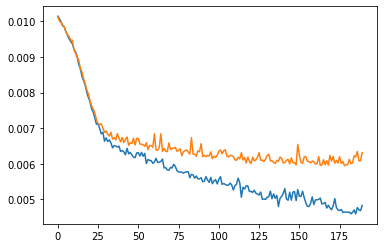

In [27]:
plt.plot(train_loss_history_alpha[10:])
plt.plot(test_loss_history_alpha[10:])

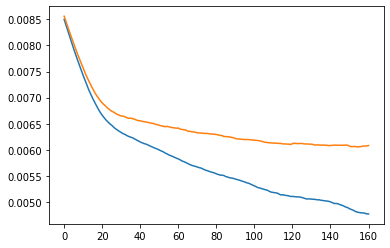

In [28]:
avg_loss_train = moving_average(train_loss_history_alpha)
avg_loss_test = moving_average(test_loss_history_alpha)
plt.plot(avg_loss_train[10:])
plt.plot(avg_loss_test[10:])

In [29]:
pred = neural_net_alpha.forward(X_validation)
pred = pred.data.cpu().numpy()
y_val = Y_validation_alpha.data.cpu().numpy()
print('Predicted\t\t\t\tReal value\t\t\t\tDifference')

sum_a1_sq = 0.0
sum_a2_sq = 0.0
sum_a1 = 0.0
sum_a2 = 0.0
sum_a1_real = 0.0
sum_a2_real = 0.0
sum_a1_pred = 0.0
sum_a2_pred = 0.0

for i in range(300):
    dif = abs(pred[i]-y_val[i])
    print(pred[i],'\t\t',y_val[i],'\t\t',dif)
    
    sum_a1_sq += dif[0]**2
    sum_a2_sq += dif[1]**2
    sum_a1 += dif[0]
    sum_a2 += dif[1]
    
    #sum_a1_pred += pred[i][0]
    #sum_a2_pred += pred[i][1]
    sum_a1_real += y_val[i][0]
    sum_a2_real += y_val[i][1] + 100*math.pi/180
    
mean_a1 = sum_a1/300
mean_a2 = sum_a2/300
mean_a1_sq = sum_a1_sq/300
mean_a2_sq = sum_a2_sq/300
relative_a1 = sum_a1/sum_a1_real
relative_a2 = sum_a2/sum_a2_real

Predicted				Real value				Difference
[ 0.1443487 -1.4721205] 		 [ 0.13421439 -1.4794816 ] 		 [0.01013431 0.00736105]
[ 0.06168425 -1.4224031 ] 		 [ 0.07932462 -1.3765831 ] 		 [0.01764036 0.04582   ]
[ 0.13437322 -1.5062008 ] 		 [ 0.1341849 -1.601973 ] 		 [0.00018832 0.09577227]
[ 0.213182  -1.3780994] 		 [ 0.20676975 -1.3520617 ] 		 [0.00641225 0.02603769]
[ 0.11334547 -1.4419389 ] 		 [ 0.01431715 -1.5409167 ] 		 [0.09902832 0.0989778 ]
[ 0.01043654 -1.5292771 ] 		 [ 0.02185441 -1.509481  ] 		 [0.01141787 0.01979613]
[ 0.14570716 -1.389158  ] 		 [ 0.04329881 -1.4344974 ] 		 [0.10240835 0.04533935]
[ 0.1671676 -1.4353476] 		 [ 0.10673419 -1.4477073 ] 		 [0.06043341 0.01235974]
[ 0.1801763 -1.2465413] 		 [ 0.2540558 -1.2159218] 		 [0.0738795 0.0306195]
[ 0.19154578 -1.4058368 ] 		 [ 0.20513718 -1.2397692 ] 		 [0.01359139 0.1660676 ]
[ 0.15126249 -1.3271244 ] 		 [ 0.00943178 -1.4278388 ] 		 [0.14183071 0.10071445]
[ 0.07227211 -1.4779644 ] 		 [ 0.0744695 -1.3414217] 		 [0.00219739 0.1365

[ 0.1753331 -1.4720864] 		 [ 0.20008466 -1.4188654 ] 		 [0.02475156 0.05322099]
[ 0.17863806 -1.2345259 ] 		 [ 0.18483803 -1.2478926 ] 		 [0.00619997 0.0133667 ]
[ 0.12730256 -1.5923936 ] 		 [ 0.13279113 -1.5777453 ] 		 [0.00548857 0.01464832]
[ 0.224958  -1.3672488] 		 [ 0.18261017 -1.5472198 ] 		 [0.04234783 0.17997098]
[ 0.16259381 -1.4574182 ] 		 [ 0.15120313 -1.589108  ] 		 [0.01139069 0.13168979]
[ 0.1473475 -1.3619757] 		 [ 0.08341216 -1.3941379 ] 		 [0.06393534 0.03216219]
[ 0.18720016 -1.3178563 ] 		 [ 0.1572966 -1.3258667] 		 [0.02990356 0.00801039]
[ 0.18620956 -1.2760978 ] 		 [ 0.10996515 -1.2865059 ] 		 [0.07624441 0.01040816]
[ 0.12715009 -1.5095067 ] 		 [ 0.07658475 -1.5589529 ] 		 [0.05056534 0.04944623]
[ 0.2252545 -1.414057 ] 		 [ 0.2474469 -1.4308298] 		 [0.02219239 0.01677275]
[ 0.15199843 -1.4642007 ] 		 [ 0.09606755 -1.4700007 ] 		 [0.05593088 0.00580001]
[ 0.15824182 -1.2820826 ] 		 [ 0.11769124 -1.308434  ] 		 [0.04055058 0.02635145]
[ 0.12013946 -1.3720391 ] 		

[ 0.1469968 -1.4754765] 		 [ 0.23332597 -1.4946356 ] 		 [0.08632918 0.01915908]
[ 0.23918101 -1.2682092 ] 		 [ 0.15901336 -1.2429683 ] 		 [0.08016765 0.0252409 ]
[ 0.02777334 -1.5337322 ] 		 [ 0.04156536 -1.4920347 ] 		 [0.01379202 0.0416975 ]
[ 0.17698993 -1.381484  ] 		 [ 0.25331527 -1.3581077 ] 		 [0.07632534 0.02337635]
[ 0.16360015 -1.4211535 ] 		 [ 0.04643454 -1.6091204 ] 		 [0.1171656  0.18796682]
[ 0.20687288 -1.4002757 ] 		 [ 0.1908078 -1.4897947] 		 [0.01606508 0.08951902]
[ 0.1529766 -1.3866949] 		 [ 0.11123504 -1.3232447 ] 		 [0.04174156 0.06345022]
[ 0.14395079 -1.387475  ] 		 [ 0.01590911 -1.4676402 ] 		 [0.12804167 0.08016515]
[ 0.15876153 -1.4766741 ] 		 [ 0.04070479 -1.7012209 ] 		 [0.11805674 0.22454679]
[ 0.21391693 -1.2694967 ] 		 [ 0.25036   -1.2483258] 		 [0.03644308 0.02117085]
[ 0.11812037 -1.5889814 ] 		 [ 0.02183494 -1.5958204 ] 		 [0.09628543 0.00683904]
[ 0.13950795 -1.5455642 ] 		 [ 0.06434475 -1.5815125 ] 		 [0.0751632  0.03594828]
[ 0.05428527 -1.6627429 

In [30]:
print('Alpha1 mean: ', mean_a1, ' / ',mean_a1*180/math.pi,'°')
print('Alpha2 mean: ', mean_a2, ' / ',mean_a2*180/math.pi,'°')
print('Alpha1 MSE: ', math.sqrt(mean_a1_sq), ' / ',math.sqrt(mean_a1*180/math.pi),'°')
print('Alpha2 MSE: ', math.sqrt(mean_a2_sq), ' / ',math.sqrt(mean_a2*180/math.pi),'°')
print('Alpha1 Relative: ', relative_a1)
print('Alpha2 Relative: ', relative_a2)

Alpha1 mean:  0.05378751351498067  /  3.081797514911268 °
Alpha2 mean:  0.06600579698880514  /  3.781853590855852 °
Alpha1 MSE:  0.06724713857405701  /  1.75550491737029 °
Alpha2 MSE:  0.0900188286121994  /  1.9446988432289078 °
Alpha1 Relative:  0.41871938307000145
Alpha2 Relative:  0.21308959576640926
